In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

functions for the genetic algorithm

In [10]:
# generating a set of feasible solutions / cronosomes
# every gene is a level where there is a call, the elements are the order in wich they are answered
def generateChronosome(size):
    chronosome = list(range(1, size+1))
    random.shuffle(chronosome)
    return chronosome

def generateChronosomes(size, m):
    chronosomes = []
    for i in range(0, m):
        chronosome = generateChronosome(size)
        chronosomes.append(chronosome)
    return chronosomes

# fitness
def countFitness(FN, CN, DF, CB, CA, DB, BFT, LT, OT, CT):
    N1 = abs(FN - CN) # N1 - number of floor between passanger and elevator
    N2 = abs(FN - DF) # N2 - number of floors between passanger and elevator
    WT = BFT + N1 + LT * CB + LT * DB + OT # waiting time of a passanger
    DT = CT + LT * CA + BFT * N2 + LT * DB + OT # destination time of a passanger
    JT = DT + WT # journey time, the obj of the EDP
    return JT

# count fitness for every chronosome
def countFitnessForChronosomes(elevator_floor, calls, chronosomes, BFT, LT, OT, CT):
    fitness_values = []
    n = len(chronosomes[0])
    FN = elevator_floor
    for chronosome in chronosomes:
        fitness = 0
        CB = 0 # CB - number of calls made before current passanger
        DB = 0 # DB - number of drops offs before current passanger
        for i in range(0, n):
            CN = calls[chronosome[i] - 1][0]
            DF = calls[chronosome[i] - 1][1]
            CA = n - i - 1 # CA - number of calls made after the current passanger
            fitness += countFitness(FN, CN, DF, CB, CA, DB, BFT, LT, OT, CT)
            CB += 1
            for j in range(chronosome[i] - 1, len(calls)):
                if FN < calls[j][1] < DF:
                    DB += 1
            FN = calls[chronosome[i] - 1][1]
        fitness_values.append(fitness / n)
    return fitness_values

# helper

def getWinner(fitness_values, chronosomes):
    sorted_indexes = np.argsort(fitness_values).tolist()
    elite_member = chronosomes[sorted_indexes[0]]
    best_fitness = fitness_values[sorted_indexes[0]]
    return elite_member, best_fitness

crossover variants

In [11]:
# helper
def fill_in_zeros(child, values, size):
    j=0
    for i in range (0, size):
        if child[i] == 0:
            child[i] = values[j]
            j += 1
    return child

def orderCrossover(parent1, parent2):
    number_of_genes = len(parent1)
    child = number_of_genes * [0]
    a = random.randint(1,number_of_genes - 1)
    b = random.randint(1,number_of_genes - 1)
    start = min(a, b)
    stop = max(a, b)
    for i in range (start, stop+1):
        child[i] = parent1[i]
    c = [i for i in parent2 if i not in child]
    child = fill_in_zeros(child, c, number_of_genes)
    return child

def position_based_crossover(parent1, parent2):
    number_of_genes = len(parent1)
    number_of_genes_to_swap = random.randint(1, number_of_genes-1)
    positions = random.sample(range(number_of_genes), number_of_genes_to_swap)
    child = [0] * number_of_genes

    for i in positions:
        child[i] = parent1[i]
    c = [i for i in parent2 if i not in child]
    child = fill_in_zeros(child, c, number_of_genes)
    return child
    
def order_based_crossover(p1, p2):
    number_of_genes = len(p1)
    number_of_genes_to_swap = random.randint(1, number_of_genes-1)
    positions_from_second_parent = random.sample(range(number_of_genes), number_of_genes_to_swap)
    child = [0] * number_of_genes
    values_in_first_parent = []
    positions_in_first_parent = []

    for i in positions_from_second_parent:
        values_in_first_parent.append(p2[i])
    
    for i in values_in_first_parent:
        positions_in_first_parent.append(p1.index(i))

    positions_in_first_parent.sort()
    j = 0
    for i in positions_in_first_parent:
        child[i] = values_in_first_parent[j]
        j += 1

    c = [i for i in p1 if i not in child]
    child = fill_in_zeros(child, c, number_of_genes)
    return child


mutation variants

In [12]:
def swapMutation(number_of_genes, mutant_member):
    a = random.randint(0, number_of_genes - 1)
    b = random.randint(0, number_of_genes - 1)
    gene = mutant_member[a]
    mutant_member[a] = mutant_member[b]
    mutant_member[b] = gene
    return mutant_member

def inversion_mutation(mutant_member):
    number_of_genes = len(mutant_member)
    a = random.randint(1,number_of_genes - 1)
    b = random.randint(1,number_of_genes - 1)
    start = min(a, b)
    stop = max(a, b)
    start = 2
    stop = 5
    cc = mutant_member[:]
    pos = stop
    for i in range(start, stop+1):
        mutant_member[i] = cc[pos]
        pos -= 1
    return mutant_member

def insertion_mutation(mutant_member):
    number_of_genes = len(mutant_member)
    positions = random.sample(range(number_of_genes), 2)
    pos1 = positions[0]
    pos2 = positions[1]
    first_half = mutant_member[:pos2]
    second_half = mutant_member[pos2:]
    if (first_half.count(mutant_member[pos1])):
        first_half.remove(mutant_member[pos1])
    elif (second_half.count(mutant_member[pos1])):
        second_half.remove(mutant_member[pos1])
    first_half.append(mutant_member[pos1])
    mutant_member = first_half + second_half
    return mutant_member

def exchange_mutation(mutant_member):
    number_of_genes = len(mutant_member)
    positions = random.sample(range(number_of_genes), 2)
    a = mutant_member[positions[0]]
    mutant_member[positions[0]] = mutant_member[positions[1]]
    mutant_member[positions[1]] = a
    return mutant_member

functions for the measurements


In [13]:
# wait time for a passenger to the elevator
def countPassangerWaitTimeForElevator(FN, CN, CB, DB, BFT, LT, OT):
    N1 = abs(FN - CN) # N1 - number of floor between passanger and elevator
    WT = BFT + N1 + LT * CB + LT * DB + OT # waiting time of a passanger
    return WT

# wait times for passangers, calculated from the solution
def calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls_from_article, solution, BFT, LT, OT):
    FN = elevator_start_floor
    calls = calls_from_article
    wait_times = []
    DB = 0
    CB = 0
    for i in range(0, len(solution)):
        CN = calls[solution[i] - 1][0]
        DF = calls[solution[i] - 1][1]
        WT = countPassangerWaitTimeForElevator(FN, CN, CB, DB, BFT, LT, OT)
        CB += 1
        for j in range(solution[i] - 1, len(calls)):
            if FN < calls[j][1] < DF:
                DB += 1
        FN = calls[solution[i] - 1][1]
        wait_times.append(WT)
    return wait_times

In [14]:
# data from x iteration
def iterateOver(max_it, genetic_i_max):
    sum_fit = 0
    waits = 0
    bests = []
    for i in range(0, max_it):
        solution, fitness, all_fitness_winners = geneticAlgorithm(
            elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
            genetic_i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
        sum_fit += fitness
        
        wait_times = calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls_from_article, solution, BFT, LT, OT)
        wait = np.mean(wait_times)
        waits += wait
        bests.append(fitness)
    avg_fitness = sum_fit / max_it
    avg_wait = waits / 60
    return avg_fitness, avg_wait, bests

for the tables

In [15]:
# every crossover and mutation
def iterateOverExtra(max_it,crossover, mutation, crossover_rate, mutation_rate, calls):
    sum_fit = 0
    waits = 0
    bests = []
    for i in range(0, max_it):
        solution, fitness, all_fitness_winners = geneticAlgorithm(
            elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls, 
            i_max, crossover_rate, mutation_rate, crossover, mutation)
        sum_fit += fitness

        wait_times = calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls, solution, BFT, LT, OT)
        wait = np.mean(wait_times)
        waits += wait
        bests.append(fitness)
    avg_fitness = sum_fit / max_it
    avg_wait = waits / 60
    return avg_fitness, avg_wait, bests


def go_over_all_crossover_and_mutation_at_rates_with_data(crossover_r, mutation_r, calls, maxi):
    crossovers = [1,2,3]
    mutations = [1,2,3,4]

    max_it = maxi

    x = 1
    for crossover in crossovers:
        for mutation in mutations:
            
            avg_fitness, avg_wait, bests =  iterateOverExtra(max_it, crossover, mutation, crossover_r, mutation_r, calls)
            
            print("E", x, "& $", round(avg_fitness, 3), "$ & $", min(bests), "$ & $", max(bests), "$ & $", round(avg_wait, 3), '$ \\\\')
            print("\hline")
            x += 1
        print()

genetic algortim

In [16]:
def geneticAlgorithm(elevator_floor, m, BFT, LT, OT, CT, number_of_genes, calls, i_max, crossover_rate, mutation_rate, crossover_type, mutation_type):
    chronosomes = generateChronosomes(number_of_genes, m)

    fitness_values = countFitnessForChronosomes(elevator_floor, calls, chronosomes, BFT, LT, OT, CT)
    all_fitness_winners = []
    
    for i in range (0, i_max):
        
        # categorisation by fitness values : elite, cross-over, mutant
        sorted_indexes = np.argsort(fitness_values).tolist()
        elite_member = chronosomes[sorted_indexes[0]]
        crossover_member_1 = chronosomes[sorted_indexes[1]]
        crossover_member_2 = chronosomes[sorted_indexes[2]]
        mutant_member = chronosomes[sorted_indexes[3]]

        sv = fitness_values[sorted_indexes[0]]

        # cross-over operations -- Davis cross-over (order crossover)
        crossover = False
        if random.uniform(0, 1) > crossover_rate:
            crossover = True
            match crossover_type:
                case 1:
                    child = orderCrossover(crossover_member_1, crossover_member_2)
                case 2: 
                    child = position_based_crossover(crossover_member_1, crossover_member_2)
                case 3:
                    child = order_based_crossover(crossover_member_1, crossover_member_2)
                
        # mutation operations -- swap mutation -- select two pos at random and swap them
        mutation = False
        if random.uniform(0, 1) > mutation_rate:
            mutation = True
            match mutation_type:
                case 1:
                    mutated = swapMutation(number_of_genes, mutant_member)
                case 2: 
                    mutated = inversion_mutation(mutant_member)
                case 3:
                    mutated = insertion_mutation(mutant_member)
                case 4:
                    mutated = exchange_mutation(mutant_member)

        # compute fitness values again after the operations
        new_chronosomes = []
        new_chronosomes.append(elite_member)
        if crossover:
            new_chronosomes.append(child)
        else:
            new_chronosomes.append(generateChronosome(number_of_genes))
        if mutation:
            new_chronosomes.append(mutated)
        else:
            new_chronosomes.append(generateChronosome(number_of_genes))
        new_chronosomes.append(generateChronosome(number_of_genes))
        chronosomes = new_chronosomes
        fitness_values = countFitnessForChronosomes(elevator_floor, calls, chronosomes, BFT, LT, OT, CT)
        fitness_values[0] = sv
        all_fitness_winners.append(sv)
    
    elite_member, best_fitness = getWinner(fitness_values, chronosomes)
    return elite_member, best_fitness, all_fitness_winners

general data

In [17]:
#  ELEVATOR
OT = 2 #opening time
CT = 2 #closing time
PLT = 5 #passangers load time
BFT = 5 #between floors
LT = OT + CT + PLT  #load time
elevator_start_floor = 4

# BUILDING
number_of_floors = 20

DOWNPEAK TRAFFIC

In [18]:
# DATA FOR GENETIC ALGORITM
i_max = 100 # generations
m = 4 # population size
crossover_rate = 0.2 # 0.2 -- 80%
mutation_rate = 0.8

#CALLS #[from, to]
calls_from_article = [[5,0], [6,0], [3,0], [11, 0], [20, 0], [10, 0], [13, 0], [1, 0], [16, 0], [1, 0]]
number_of_genes = len(calls_from_article)

# crossover types: 
# 1-order crossover 
# 2-position crossover 
# 3-order based crossover
crossover_type = 1

# mutation types: 
# 1-swap mutation 
# 2-inversion mutation 
# 3-insertion mutation 
# 4-exchange mutation
mutation_type = 1

In [19]:
i_max =  100
solution, fitness, all_fitness_winners = geneticAlgorithm(
    elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
    i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
print(fitness)

100.6


In [20]:
## waiting time of a passanger

wait_times = calculateWaitTimesForElevatorFromChronosome(elevator_start_floor, calls_from_article, solution, BFT, LT, OT)
print("wait times for each passanger", wait_times)
print("avg wait times for the elevator to arrive in sec", np.mean(wait_times))

wait times for each passanger [9, 17, 36, 35, 48, 72, 77, 80, 82, 101]
avg wait times for the elevator to arrive in sec 55.7


In [21]:
max_it = 100
min_g_a_gens = 10
max_g_a_gens = 100
step = 10

f_n = []
its = []

for i in range(min_g_a_gens, max_g_a_gens + 1, step):
    its.append(i)
    avg_fitness, avg_wait, bests =  iterateOver(max_it, i)
    f_n.append(avg_fitness)
    print(i)
print(f_n)

10
20
30
40
50
60
70
80
90
100
[100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018]


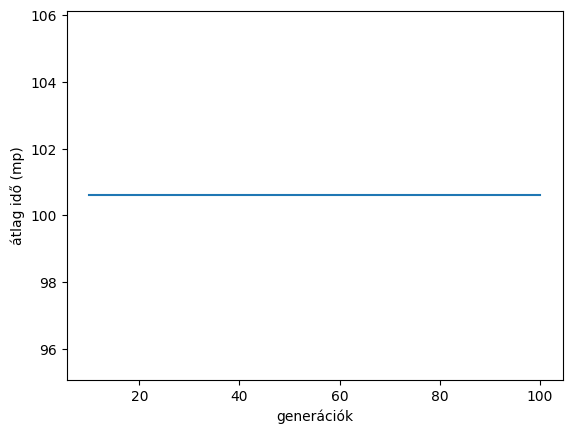

[100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018, 100.60000000000018]


In [22]:
xpoints = np.array(list(range(min_g_a_gens, max_g_a_gens +1 , step)))
ypoints = np.array(f_n)

plt.xlabel("generációk")
plt.ylabel("átlag idő (mp)")

plt.plot(xpoints, ypoints)
plt.show()

print(f_n)

In [23]:
calls = calls_from_article
crossover_r = 0.8 # 0.8 --- 20%
mutation_r = 0.2

go_over_all_crossover_and_mutation_at_rates_with_data(crossover_r, mutation_r, calls, i_max)

E 1 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.077 $ \\
\hline
E 2 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.11 $ \\
\hline
E 3 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.047 $ \\
\hline
E 4 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.07 $ \\
\hline

E 5 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.087 $ \\
\hline
E 6 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.023 $ \\
\hline
E 7 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.127 $ \\
\hline
E 8 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.133 $ \\
\hline

E 9 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.117 $ \\
\hline
E 10 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.033 $ \\
\hline
E 11 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.033 $ \\
\hline
E 12 & $ 100.6 $ & $ 100.6 $ & $ 100.6 $ & $ 93.107 $ \\
\hline



In [24]:
all_calls = []

for i in range (0, 10):
    new_calls = []
    start_floors = random.sample(range(1, 20), 10)
    for s in start_floors:
        new_calls.append([s, 0])
    all_calls.append(new_calls)

In [25]:
for call in all_calls:
    print(call)

[[13, 0], [12, 0], [5, 0], [3, 0], [11, 0], [17, 0], [14, 0], [4, 0], [2, 0], [7, 0]]
[[12, 0], [9, 0], [7, 0], [10, 0], [16, 0], [1, 0], [15, 0], [13, 0], [17, 0], [3, 0]]
[[13, 0], [8, 0], [6, 0], [11, 0], [12, 0], [9, 0], [3, 0], [19, 0], [18, 0], [14, 0]]
[[18, 0], [17, 0], [5, 0], [9, 0], [6, 0], [10, 0], [13, 0], [7, 0], [11, 0], [14, 0]]
[[18, 0], [2, 0], [12, 0], [6, 0], [17, 0], [3, 0], [9, 0], [15, 0], [7, 0], [1, 0]]
[[9, 0], [10, 0], [16, 0], [18, 0], [13, 0], [14, 0], [6, 0], [15, 0], [19, 0], [5, 0]]
[[3, 0], [1, 0], [4, 0], [14, 0], [18, 0], [6, 0], [19, 0], [9, 0], [7, 0], [11, 0]]
[[18, 0], [12, 0], [7, 0], [4, 0], [15, 0], [6, 0], [9, 0], [8, 0], [10, 0], [3, 0]]
[[14, 0], [18, 0], [1, 0], [10, 0], [5, 0], [4, 0], [12, 0], [16, 0], [17, 0], [3, 0]]
[[12, 0], [16, 0], [11, 0], [6, 0], [17, 0], [1, 0], [7, 0], [5, 0], [4, 0], [19, 0]]


In [26]:
i_max = 100
fitnesses = []
for call in all_calls:
    number_of_genes = len(call)
    solution, fitness, all_fitness_winners = geneticAlgorithm(
    elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, call, 
    i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
    fitnesses.append(fitness)
print(np.mean(fitnesses))

102.10999999999999


floors

In [27]:
all_calls = []
max_level = 5

downpeak = False

for i in range (0, 10):
    new_calls = []
    start_floors = np.random.randint(1,max_level, size=10)
    for s in start_floors:
        if downpeak:
            new_calls.append([s, 0])
        else:
            new_calls.append([s, random.randint(0,max_level)])
    all_calls.append(new_calls)

In [28]:
for call in all_calls:
    print(call)

[[2, 5], [2, 0], [4, 2], [2, 3], [4, 5], [3, 1], [4, 0], [3, 4], [4, 5], [2, 4]]
[[3, 3], [1, 3], [1, 4], [2, 4], [3, 2], [4, 0], [1, 4], [1, 1], [1, 2], [2, 0]]
[[4, 4], [4, 4], [1, 3], [2, 0], [2, 4], [3, 5], [3, 5], [3, 0], [1, 4], [3, 0]]
[[1, 0], [2, 3], [1, 1], [3, 0], [4, 0], [4, 1], [4, 3], [2, 1], [1, 5], [2, 0]]
[[2, 1], [1, 5], [4, 2], [2, 0], [2, 0], [4, 3], [1, 2], [2, 2], [1, 5], [1, 2]]
[[3, 0], [4, 4], [1, 5], [4, 2], [1, 3], [1, 5], [2, 0], [1, 5], [4, 0], [3, 1]]
[[3, 3], [2, 3], [1, 2], [2, 4], [4, 0], [4, 0], [3, 3], [4, 5], [1, 1], [4, 0]]
[[3, 0], [4, 4], [3, 0], [2, 1], [2, 2], [3, 2], [2, 4], [2, 4], [1, 2], [4, 5]]
[[1, 4], [3, 5], [1, 5], [2, 1], [4, 2], [3, 0], [3, 2], [3, 4], [2, 3], [4, 0]]
[[4, 4], [1, 5], [3, 0], [2, 2], [4, 3], [2, 3], [1, 2], [3, 2], [4, 2], [2, 4]]


In [29]:
generations = 1000
fitnesses = []
for call in all_calls:
    number_of_genes = len(call)
    solution, fitness, all_fitness_winners = geneticAlgorithm(
    elevator_start_floor, m, BFT, LT, OT, CT, number_of_genes, call, 
    generations, crossover_rate, mutation_rate, crossover_type, mutation_type)
    fitnesses.append(fitness)
print(np.mean(fitnesses))

97.53


In [30]:
print(fitnesses)

[96.7, 97.0, 97.7, 97.0, 97.2, 99.1, 97.5, 96.8, 99.4, 96.9]


In [31]:
solution

[10, 2, 1, 5, 6, 9, 8, 4, 7, 3]

In [32]:
avg_fitness, avg_wait, bests = iterateOver(100, 1000)
print(avg_fitness)

100.60000000000018
